In [101]:
from signal_generator import generate_zigzag_signal, generate_circle_signal, plot_acceleration, plot_trajectory
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [102]:
def plot_spectrum(time, signal, fs):
    N = len(time)
    spectrum = np.fft.fft(signal)  # discrete Fourier-transform
    spectrum_db = 20 * np.log10(np.abs(spectrum) + 1e-12)  # 1e-12 prevents log(0)
    frequencies = np.fft.fftfreq(N, 1 / fs)  # frequency vector
    plt.plot(frequencies, spectrum_db)
    plt.title('Frequenzspektrum')
    plt.xlabel('Frequenz [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(True)
    plt.show()

In [103]:
def calculate_trajectory(acceleration, fs, v0, p0, filtering):
    # Rechteckregel
    # H(z)=1/(1-z^-1)
    b = [1]         # coefficients for nominator
    a = [1, -1]     # coefficients for denominator

    from scipy.signal import savgol_filter

    if filtering:
        # smooth out acceleration values
        acceleration[:, 1] = savgol_filter(acceleration[:, 1], window_length=21, polyorder=3)
        acceleration[:, 2] = savgol_filter(acceleration[:, 2], window_length=21, polyorder=3)
        acceleration[:, 3] = savgol_filter(acceleration[:, 3], window_length=21, polyorder=3)

    # remove bias from acceleration
    acceleration[:, 1] -= np.mean(acceleration[:, 1])
    acceleration[:, 2] -= np.mean(acceleration[:, 2])
    acceleration[:, 3] -= np.mean(acceleration[:, 3])

    # time interval
    dt = 1 / fs  

    # first integration
    vx = lfilter(b, a, acceleration[:, 1]) * dt + v0[0]
    vy = lfilter(b, a, acceleration[:, 2]) * dt + v0[1]
    vz = lfilter(b, a, acceleration[:, 3]) * dt + v0[2]
    
    # remove bias from velocity
    vx -=np.mean(vx)
    vy -=np.mean(vy)
    vz -=np.mean(vz)

    # second integration
    px = lfilter(b, a, vx) * dt + p0[0]
    py = lfilter(b, a, vy) * dt + p0[1]
    pz = lfilter(b, a, vz) * dt + p0[2]

    position = np.vstack([px, py, pz])
    position = np.transpose(position)
    
    return position

In [104]:
def calculate_rmse(position_1, position_2):
    n = len(position_1)
    rmse = np.sqrt(1/n * np.sum((position_1 - position_2)**2))
    
    return rmse

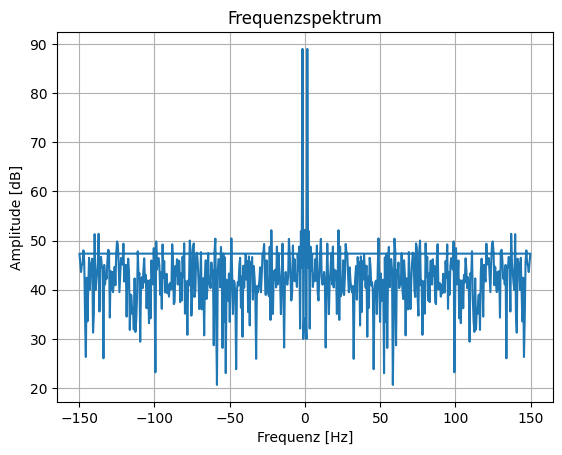

In [105]:
fs = 300
acceleration, position = generate_circle_signal(v=10, fs=fs, p=3, snr=20)
t = acceleration[:, 0]
ax = acceleration[:, 1]
plot_spectrum(t, ax, fs)

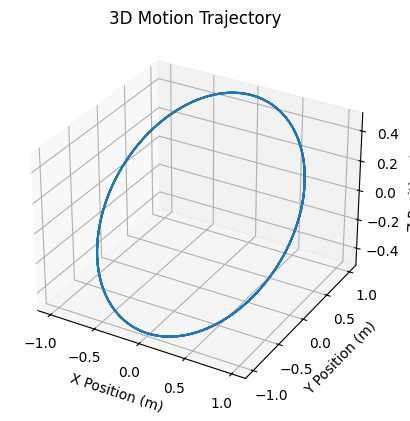

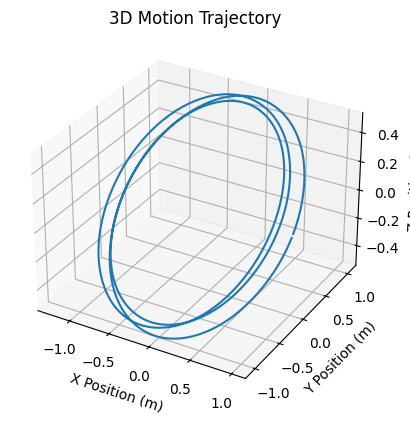

In [106]:
# circular trajectory
# parameters
v0 = [0, 10, 5]  # start velocity [vx0, vy0, vz0]  # irrelevant because v_mean should be 0
p0 = [1.0, 0, 0]  # start position [px0, py0, pz0]
fs = 300

acceleration, position = generate_circle_signal(v=10, fs=fs, p=3, snr=20)
calculated_position = calculate_trajectory(acceleration, fs, v0, p0, True)
plot_trajectory(position)
plot_trajectory(calculated_position)

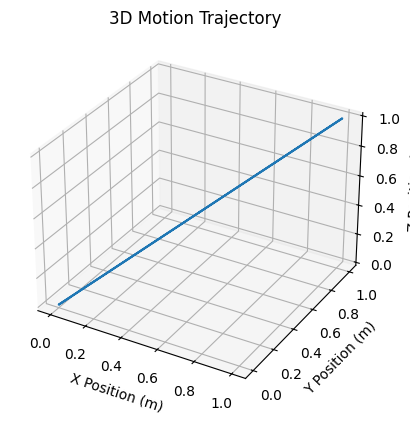

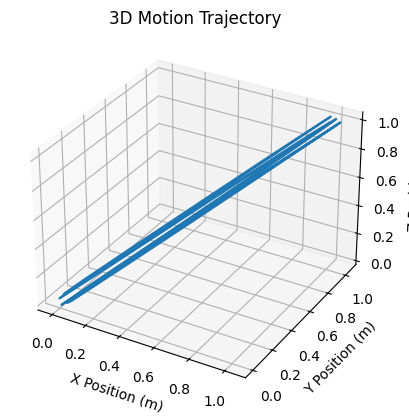

In [107]:
# zigzag trajectory
# parameters
v0 = [1.81, 1.81, 1.81]  # start velocity for v=1  (irrelevant because v_mean should be 0)
p0 = [0.5, 0.5, 0.5]  # start position is at the middle of A and B!
fs = 300

acceleration, position = generate_zigzag_signal(A=(0,0,0), B=(1,1,1), v=1, fs=fs, p=5, snr=20)
calculated_position = calculate_trajectory(acceleration, fs, v0, p0, True)
plot_trajectory(position)
plot_trajectory(calculated_position)

### Error(SNR) for circular trajectory

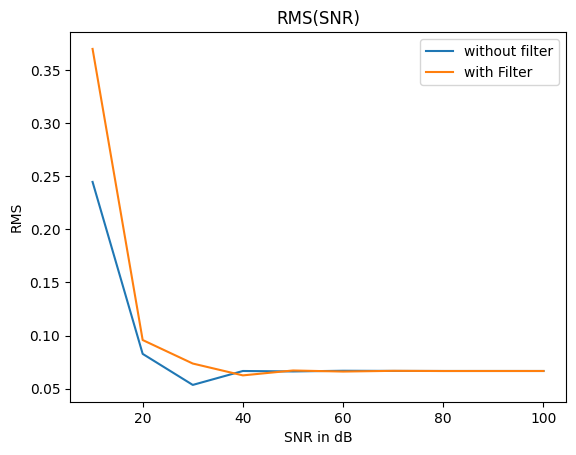

In [113]:
snr = np.linspace(10.0, 100.0, 10)
rms_no_filter = []
rms_filter = []
v0 = [0, 10, 5]  # start velocity [vx0, vy0, vz0]  # irrelevant because v_mean should be 0
p0 = [1.0, 0, 0]  # start position [px0, py0, pz0]
fs = 300

for current_snr in snr:
    acceleration, position = generate_circle_signal(v=10, fs=fs, p=3, snr=current_snr)
    calculated_position = calculate_trajectory(acceleration, fs, v0, p0, False)
    current_rms = calculate_rmse(position, calculated_position)
    rms_no_filter.append(current_rms)
    
for current_snr in snr:
    acceleration, position = generate_circle_signal(v=10, fs=fs, p=3, snr=current_snr)
    calculated_position = calculate_trajectory(acceleration, fs, v0, p0, True)
    current_rms = calculate_rmse(position, calculated_position)
    rms_filter.append(current_rms)

plt.plot(snr, rms_no_filter, label="without filter")
plt.plot(snr, rms_filter, label="with Filter")
plt.xlabel("SNR in dB")
plt.ylabel("RMS")
plt.title("RMS(SNR)")
plt.legend()
plt.show()